In [10]:
# models
from n2v import N2VModel
from s2v import S2VModel

# utility
import numpy as np
import argparse
import matplotlib.pyplot as plt
import data_util as du
from util import parameters

# arguments
params = parameters.get_parameters(notebook=True)

In [15]:
import time
timestr = time.strftime("%Y%m%d-%H%M%S")

## Diagram

Currently the following pipeline is used

In [ ]:
## Train Model


## Loading Data
Currently t

== LOADING DATA FROM data/tissue_int.edgelist ==



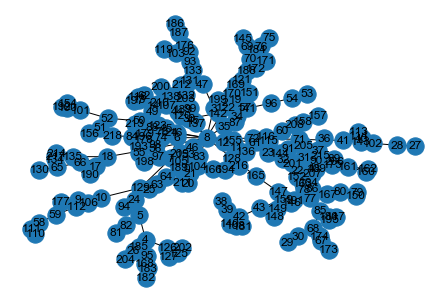

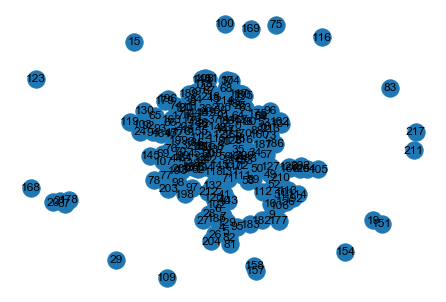

In [12]:
# load data
print(f'== LOADING DATA FROM {edge_list} ==')
data = du.load_edge_list(edge_list)
if show_vis:
    print('')
    v = du.vis_graph(data)
    plt.show(v)

train_data = du.add_noise(data, n_remove=50, n_add=50)

if show_vis:
    v = du.vis_graph(train_data)
    plt.show(v)

## Training the model
The node2vec model is trained, this gives us the node embeddings to determine similarity between nodes, and more importantly, the edge embeddings. 

In [13]:
def train_model(data, model_type, embed_dim, model_fname):
    if model_type == 'n2v':
        nv_emb = N2VModel(embed_dim=embed_dim,
                          emb_name='l2',
                          c_idx=-1,
                          model_fname=model_fname)
        nv_emb.fit(data)
        return nv_emb
    elif model_type == 's2v':
        sv_emb = S2VModel(embed_dim=embed_dim,
                          emb_name='l2',
                          c_idx=-1,
                          model_fname=model_fname)
        sv_emb.fit(data)
        return sv_emb

# train model
print(f'== TRAINING {model_type} MODEL  ==')
model = train_model(train_data, model_type,
                    embed_dim, model_fname)

== TRAINING s2v MODEL  ==


Generating edge features: 100%|██████████| 21321/21321.0 [00:00<00:00, 135751.37it/s]


## Edge Embeddings
As we can see in the visualisations below, embeddings are defined for all possible edges, not just edges that exist in the graph. However, directionality is discarded after embedding. Due to the nature of the implemented edge embeddings, an edge from node 1 to node 2 will output the same edge embedding as an edge from node 2 to node 1. For example, the Hadamard embedding will multiply the node embeddings of node 1 and node 2 together. More info at this link: https://github.com/eliorc/node2vec/issues/36

Nodes


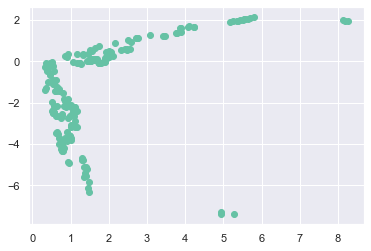

Edges


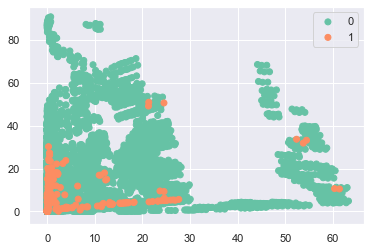

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import gensim as gs
from sklearn.manifold import TSNE
import numpy as np
import re

# some theme compatability issues
pal = sns.color_palette('Set2')
cmap = sns.color_palette('Set2', as_cmap=True)
c1 = cmap(0)
c2 = cmap(1)
sns.set_theme(palette=pal)
graph_vis_options = {
    "font_size": 24,
    "node_size": 1000,
    "linewidths": 5,
    "arrows": True,
    "width": 5,
    "node_color": c1,
    "edge_color": c2
}

print('Nodes')
fig2dnodes = du.vis_embeddings(model.nodes)
plt.show()

print('Edges')
edge_labels = du.construct_embedding_labels(data, model.ee_kv)
embeddings2dedges = du.vis_edge_embeddings(data, model.ee_kv.vectors, edge_labels)
plt.show()

## Classifier
Classify points

In [15]:
# classify
print(f'== TESTING MODEL  ==')
score = model.score(data)
print(f'Score for {model_type}: {score}')

== TESTING MODEL  ==
Score for s2v: 0.9904319684817785


In [19]:
# construct labels for set of all possible edges in graph
edge_labels = du.construct_embedding_labels(data, model.ee_kv)
print(f'#possible_labels: {len(edge_labels)}, #true_labels: {sum(edge_labels)}')

# get all feature vector names (edge1, edge2)
feats = []
keys = model.ee_kv.vocab.keys()

# for each edge in data, get feature vector
for edge in data.edges:
    feat_vec = None
    
#     convert edge to string
    edge = str(edge)
    e1, e2 = du.edge_str2tuple(edge)
    r_edge = f"('{e2}', '{e1}')"
#   if edge found save
    if edge in keys:
        feat_vec = model.ee_kv[edge]
#   if edge not found, get reverse edge
    elif r_edge in keys:
        feat_vec = model.ee_kv[r_edge]
    else:
        print("???????", edge)

# append to feats
    feats.append(feat_vec)
feats = np.array(feats)
# gen predictions for data
preds = model.clf.predict(feats)
data_labels = np.ones(feats.shape[0])

embeddings2dedges = du.vis_edge_embeddings(data, model.ee_kv.vectors, data_labels)


#possible_labels: 21321, #true_labels: 204
??????? ('8', '83')
??????? ('95', '168')
??????? ('16', '15')
??????? ('83', '21')
??????? ('61', '116')
??????? ('124', '123')
??????? ('135', '217')
??????? ('21', '211')
??????? ('22', '109')
??????? ('29', '30')
??????? ('101', '100')
??????? ('101', '154')
??????? ('76', '75')
??????? ('170', '169')


/opt/anaconda3/envs/rl1/lib/python3.7/site-packages/ipykernel_launcher.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


ValueError: setting an array element with a sequence.

## Problem
We can see below that the problem with the current classifier is that it predicts all edges to be non-existant. This way it will always have a good accuracy. 

In [ ]:
edge_labels = du.construct_embedding_labels(data, model.ee_kv)
preds = model.clf.predict(model.ee_kv.vectors)
print(preds)
print("Number of class 1 predictios", sum(preds))
correct = (edge_labels == preds)
embeddings2dedges = du.vis_edge_embeddings(data, model.ee_kv.vectors, correct)
